# Run-time vs Accuracy Figures

This notebook plots the runn-time vs accuracy figures, comparing NSIL to the baselines. For quick access to a particular experiment, please click on the corresponding link here:

| **Addition**  | **E9P** | **HS** | **CHS** |
| ----------- | ----------- | ----------- | ----------- |
| [100% Training Data](#mnist_addition_100_pct) | [100% Training Data](#mnist_alternative_hyp_100_pct) | [MNIST](#hitting_sets_mnist) | [MNIST](#hitting_sets_alternative_hyp_mnist) |
| [10% Training Data](#mnist_addition_10_pct) | [10% Training Data](#mnist_alternative_hyp_10_pct) | [FashionMNIST](#hitting_sets_fashion_mnist) | [FashionMNIST](#hitting_sets_alternative_hyp_mnist) |
| [5% Training Data](#mnist_addition_5_pct) | [5% Training Data](#mnist_alternative_hyp_5_pct) |

In [75]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
import json
import datetime
from os.path import join
from scipy.stats import sem

In [76]:
# Helper functions
def atof(text):
    try:
        retval = float(text)
    except ValueError:
        retval = text
    return retval

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    float regex comes from https://stackoverflow.com/a/12643073/190597
    '''
    return [ atof(c) for c in re.split(r'[+-]?([0-9]+(?:[.][0-9]*)?|[.][0-9]+)', text) ]

In [77]:
def calculate_nsl_epoch_times(nsl_run_dir):
    epoch_times = [0]
    read=False
    train_details_file = nsl_run_dir+'/train_details.txt'
    for line in open(train_details_file):
        if '"total_without_test": ' in line.strip():
            val = line.strip().split(': ')[1]
            epoch_times.append(epoch_times[-1] + float(val))
            read = True
            continue
        elif line.strip() == '---------------------':
            read = False
    return np.array(epoch_times)

In [78]:
def calculate_baseline_epoch_times_cumulative(b_run_dir):
    if 'meta_abd' in b_run_dir:
        b_time_file = open(b_run_dir+'/epoch_times.txt', 'r').read()
        times = [float(t) for t in b_time_file.split('\n') if t != '']
    else:
        b_time_file = open(b_run_dir+'/train_time.txt','r').read()
        times = json.loads(b_time_file.split('epoch_times: ')[1])
    all_times = [0]
    for t in times:
        all_times.append(all_times[-1] + t)
    return np.array(all_times)

In [79]:
def get_all_nsl_repeat_times(nsl_run_dir, nsl_repeats):
    all_times = []
    for i in nsl_repeats:
        repeat_dir = nsl_run_dir+'/'+i
        repeat_times = calculate_nsl_epoch_times(repeat_dir)
        all_times.append(repeat_times)
    stacked = np.vstack(all_times)
    mean = np.mean(stacked,axis=0)
    err = sem(stacked, axis=0)
    return mean, err
    

In [80]:
def get_all_baseline_repeat_times(baseline_run_dir, b_repeats):
    all_times = []
    max_len = 0
    for i in b_repeats:
        repeat_dir = baseline_run_dir+'/'+i
        repeat_times = calculate_baseline_epoch_times_cumulative(repeat_dir)
        all_times.append(repeat_times)
        if len(repeat_times) > max_len:
            max_len = len(repeat_times)
    for idx, t in enumerate(all_times):
        if len(t) < max_len:
            for j in range(max_len - len(t)):
                all_times[idx] = np.append(all_times[idx],np.NAN)    
    stacked = np.vstack(all_times)
    mean = np.nanmean(stacked, axis=0)
    err = sem(stacked, axis=0)
    return mean, err

In [81]:
def plot(example_dir, 
         baselines,
         save_name,
         dataset_pct=100,
         num_epochs=20,
         save_legend=False,
         max_x_val=1000,
         dataset=None,
         y_lim=[-0.05, 1.05]):
    
    baseline_base_dir = example_dir+'/baselines/saved_results'
    nsl_repeats_dir = example_dir+'/saved_results'
    
    if dataset is not None:
        baseline_base_dir = baseline_base_dir+'/'+dataset
        nsl_repeats_dir = nsl_repeats_dir+'/repeats/'+dataset
    else:
        nsl_repeats_dir = nsl_repeats_dir+'/repeats'
    
    # Build NSL results
    # Each x,y point is mean time taken and mean test accuracy at each epoch
    nsl_X = []
    nsl_y = []
    nsl_errs = []
    nsl_dir = nsl_repeats_dir+'/'+str(dataset_pct)
    repeats = os.listdir(nsl_dir)
    repeats = [r for r in repeats if r != '.DS_Store']
    repeats.sort(key=natural_keys)
    
    # Get mean times and err at each epoch
    nsl_mean_times, nsl_times_err = get_all_nsl_repeat_times(nsl_dir, repeats)
    
    full_range = num_epochs + 1    
    for epoch_num in range(full_range):
        acc_results_epoch = []
        for idx, i in enumerate(repeats):
            # Read in test_log and get end-to-end accuracy at this epoch
            with open(join(nsl_dir, i, 'test_log.json'), 'r') as jf:
                tl = json.loads(jf.read())
                acc = tl[str(epoch_num)]['end_to_end_acc']
            acc_results_epoch.append(acc)
            
        # Compute mean and std err across all repeats
        nsl_y.append(np.mean(acc_results_epoch))
        nsl_errs.append(sem(acc_results_epoch))
        
    # Build baseline results
    baseline_results = {}  
    for b_idx, b in enumerate(baselines):            
        b_dir = baseline_base_dir+'/'+b+'/'+str(dataset_pct)
        b_repeats = os.listdir(b_dir)
        b_repeats = [b_r for b_r in b_repeats if b_r != '.DS_Store']
        b_repeats = [b_r for b_r in b_repeats if 'csv' not in b_r]
        b_repeats = [b_r for b_r in b_repeats if 'txt' not in b_r]
        b_repeats.sort(key=natural_keys)
            
        baseline_results[b] = {
            "accuracy": {"means": [], "errs": []},
            "times": get_all_baseline_repeat_times(b_dir, b_repeats)
        }
        
        for epoch_num in range(full_range):
            all_b_results_epoch = []
            for idx, i in enumerate(b_repeats):
                # Read in test_log and get accuracy for this epoch
                if b == 'meta_abd':
                    b_tl = pd.read_csv(b_dir+'/'+i+'/test.csv')
                    if epoch_num in b_tl['task_accuracy']:
                        acc = b_tl['task_accuracy'][epoch_num]
                        all_b_results_epoch.append(acc)
                    else:
                        print(f'Warning: Epoch {epoch_num} not in Meta_Abd {dataset_pct}% repeat {i}')
                else:
                    b_tl = pd.read_csv(b_dir+'/'+i+'/test_log.csv')
                    acc = b_tl['accuracy'][epoch_num]
                    all_b_results_epoch.append(acc)
                
            # Calculate mean and stderr
            if len(all_b_results_epoch) > 0:
                baseline_results[b]['accuracy']['means'].append(np.mean(all_b_results_epoch))
                baseline_results[b]['accuracy']['errs'].append(sem(all_b_results_epoch))
        
    # Plot graph
    figure_handles = []
    figure_labels = []
    fig = plt.figure("data figure")
    legend_fig = plt.figure("legend figure")
    ax = fig.add_subplot(111)
    
    # Plot NSL
    
    nsl_plot, = ax.plot(nsl_mean_times+1, nsl_y, color="k")
    figure_handles.append(nsl_plot)
    figure_labels.append('NSIL')
    ax.errorbar(nsl_mean_times +1, nsl_y, nsl_errs, color="k", capsize=5)
    
    # Plot Baselines
    b_colours = ['b', 'g', 'r', 'm', 'c', 'tab:brown']
    b_lines = ["--","-.",":", ":", ":", ":"]
    markers = [None, None, None, "d", "x", "^"]
    for idx, b in enumerate(baselines):
        b_times, b_time_errs = baseline_results[b]['times']
        b_plot, = ax.plot(b_times +1,
                          baseline_results[b]['accuracy']['means'], 
                          linestyle=b_lines[idx],
                          color=b_colours[idx],
                          marker=markers[idx])
        
        figure_handles.append(b_plot)
        figure_labels.append(baselines[b])
        
        ax.errorbar(b_times + 1, 
                    baseline_results[b]['accuracy']['means'],
                    baseline_results[b]['accuracy']['errs'],
                    color=b_colours[idx],
                    linestyle=b_lines[idx],
                    capsize=5)
   
    ax.set_xlabel('Time (s)', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.grid()
    ax.set_ylim(y_lim)
    ax.xaxis.set_tick_params(labelsize=10)
    ax.yaxis.set_tick_params(labelsize=10)
    ax.set_xscale('log')
    plt.show()
    

    
    
    base_dir = '../figures/run-time_vs_accuracy/'
    if save_legend:
        legend_fig.legend(figure_handles, figure_labels, loc='center', ncol=len(baselines)+1)
        legend_fig.savefig(base_dir+save_name, bbox_inches='tight')
    else:
        fig.savefig(base_dir+save_name, bbox_inches='tight')
    

# Figures

### Arithmetic Sum

In [82]:
# Example directory
example_name = 'arithmetic'
dataset='sum'
example = '../../../examples/'+example_name

# Baseline ID with display name
baseline_info = {
    'cnn': 'CNN', 
    'cbm_joint_lambda_0': 'CBM',
    'cbm_joint_lambda_0_with_softmax': 'CBM-S',
    'cnn_lstm_nac': 'CNN-LSTM-NAC',
    'cnn_lstm_nalu': 'CNN-LSTM-NALU',
    'meta_abd': 'Meta_Abd'
}

### Legend
`%%capture` prevents the figure from showing inline

In [83]:
%%capture
plot(example, baseline_info, dataset=dataset, save_name='legend.pdf', save_legend=True)

<a id='mnist_addition_100_pct'></a>
### 100% Training Data

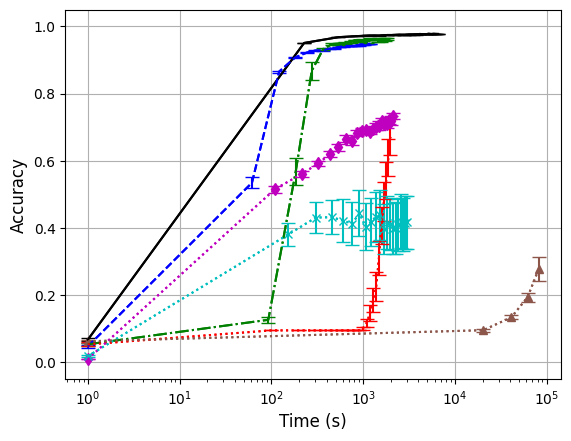

<Figure size 640x480 with 0 Axes>

In [84]:
plot(example, 
     baseline_info, 
     dataset=dataset,
     save_name=f'{example_name}_{dataset}_100_pct.pdf',
     max_x_val=1000)

<a id='mnist_addition_10_pct'></a>
### 10% Training Data

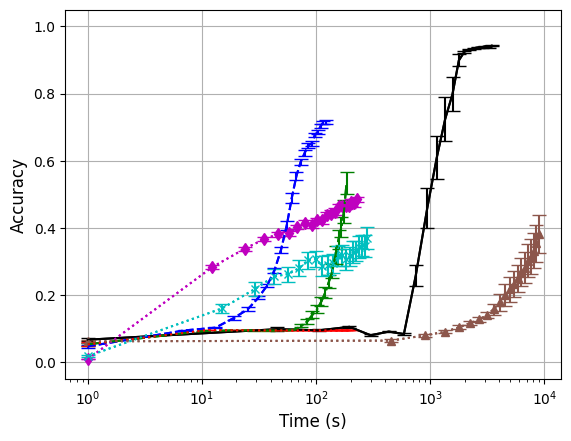

<Figure size 640x480 with 0 Axes>

In [85]:
plot(example, 
     baseline_info, 
     dataset_pct=10,
     dataset=dataset,
     save_name=f'{example_name}_{dataset}_10_pct.pdf')

<a id='mnist_addition_5_pct'></a>
### 5% Training Data

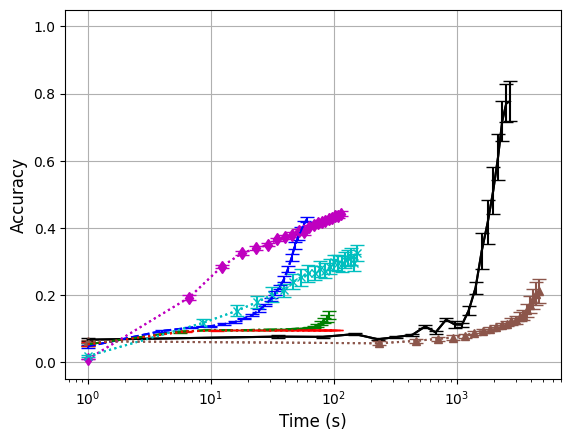

<Figure size 640x480 with 0 Axes>

In [86]:
plot(example, 
     baseline_info, 
     dataset_pct=5,
     dataset=dataset,
     save_name=f'{example_name}_{dataset}_5_pct.pdf')

### Arithmetic E9P

In [87]:
dataset = 'e9p'
baseline_info = {
    'cnn': 'CNN', 
    'cbm_joint_lambda_0': 'CBM',
    'cbm_joint_lambda_0_with_softmax': 'CBM-S',
    'cnn_lstm_nac': 'CNN-LSTM-NAC',
    'cnn_lstm_nalu': 'CNN-LSTM-NALU'
}

<a id='mnist_alternative_hyp_100_pct'></a>
### 100% Training Data

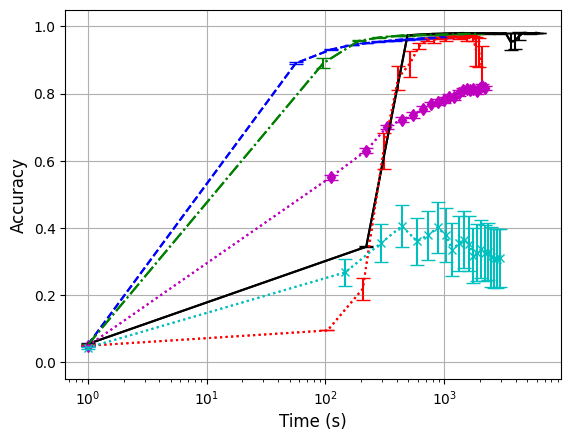

<Figure size 640x480 with 0 Axes>

In [88]:
plot(example, 
     baseline_info, 
     dataset=dataset,
     save_name=f'{example_name}_{dataset}_100_pct.pdf')

<a id='mnist_alternative_hyp_10_pct'></a>
### 10% Training Data

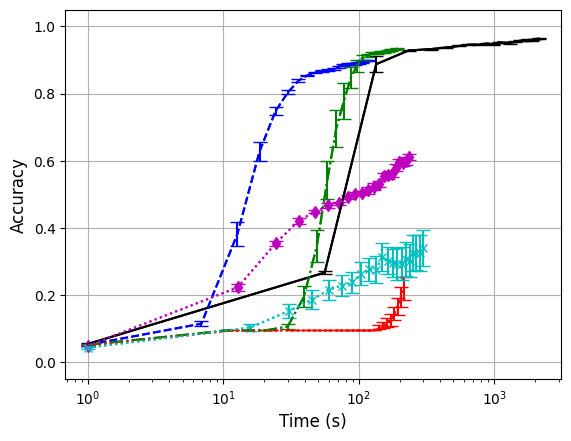

<Figure size 640x480 with 0 Axes>

In [89]:
plot(example, 
     baseline_info, 
     dataset_pct=10,
     dataset=dataset,
     save_name=f'{example_name}_{dataset}_10_pct.pdf')

<a id='mnist_alternative_hyp_5_pct'></a>
### 5% Training Data

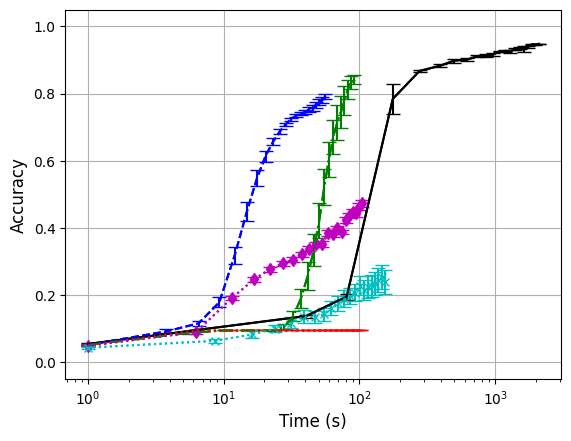

<Figure size 640x480 with 0 Axes>

In [90]:
plot(example, 
     baseline_info, 
     dataset_pct=5,
     dataset=dataset,
     save_name=f'{example_name}_{dataset}_5_pct.pdf')

## HS

In [99]:
# Example directory
example_name = 'hitting_sets'
example = '../../../examples/'+example_name

# Baseline ID with display name
baseline_info = {
    'cnn_lstm': 'CNN-LSTM', 
    'cbm_joint_lambda_0': 'CBM',
    'cbm_joint_lambda_0_with_softmax': 'CBM-S'
}

<a id='hitting_sets_mnist'></a>
### MNIST

In [100]:
dataset='HS_mnist'

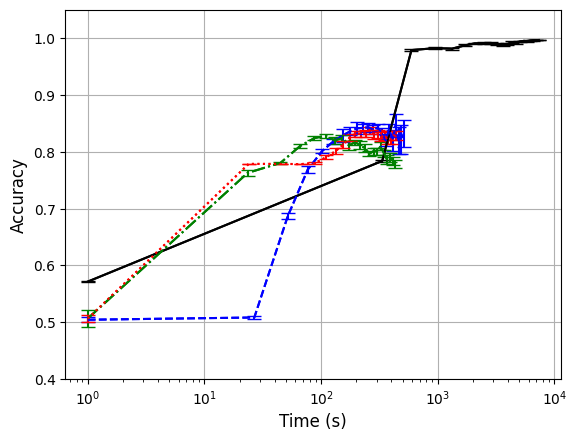

<Figure size 640x480 with 0 Axes>

In [101]:
plot(example, 
     baseline_info, 
     save_name=f'{example_name}_{dataset}.pdf',
     dataset=dataset,
     y_lim=[0.4, 1.05])

<a id='hitting_sets_fashion_mnist'></a>
### FashionMNIST

In [102]:
dataset='HS_fashion_mnist'

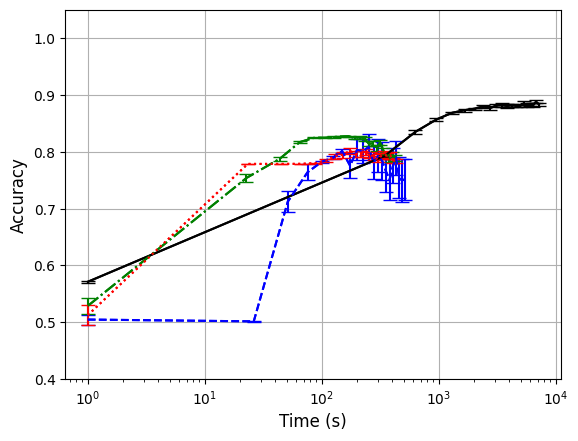

<Figure size 640x480 with 0 Axes>

In [103]:
plot(example, 
     baseline_info, 
     save_name=f'{example_name}_{dataset}.pdf',
     dataset=dataset,
     y_lim=[0.4, 1.05])

## CHS

<a id='hitting_sets_alternative_hyp_mnist'></a>
### MNIST

In [104]:
dataset='CHS_mnist'

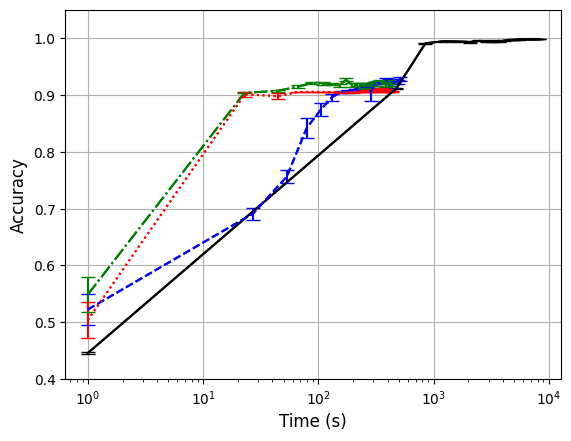

<Figure size 640x480 with 0 Axes>

In [105]:
plot(example, 
     baseline_info, 
     save_name=f'{example_name}_{dataset}.pdf',
     dataset=dataset,
     y_lim=[0.4, 1.05])

<a id='hitting_sets_alternative_hyp_fashion_mnist'></a>
### FashionMNIST

In [106]:
dataset = 'CHS_fashion_mnist'

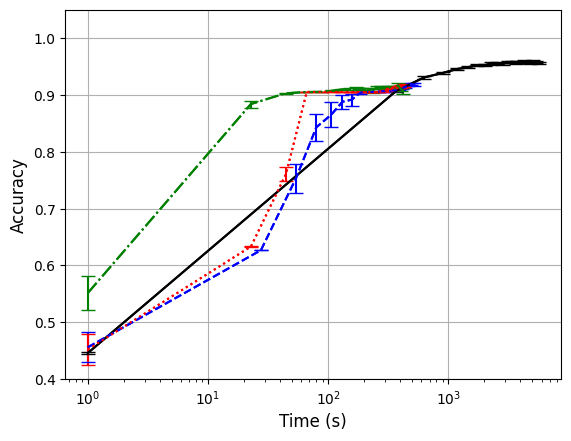

<Figure size 640x480 with 0 Axes>

In [107]:
plot(example, 
     baseline_info, 
     save_name=f'{example_name}_{dataset}.pdf',
     dataset=dataset,
     y_lim=[0.4, 1.05])